In [5]:
import pandas as pd

In [6]:
# Importing all the libraries
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

In [7]:
# In this step all the dependent vairables are read into the train_x_value
train_y = pd.read_csv("C://Users//likhi//Downloads//Training_data_targets.csv")

# In this step all the training data expect the target variable data is loaded
train_x = pd.read_csv("C://Users//likhi//Downloads//Training_data.csv")

,TARGET_deathRate
0,199.5
1,137.1
2,126.9
3,173.8
4,179.8
...,...
2433,201.5
2434,160.0
2435,160.0
2436,136.2


### EXPLORATORY DATA ANALYSIS PHASE 

Univariate analysis using histograms and boxplots. With the Histograms plots against the target variable will show results to delete the uncessary rows with alots of missing values and Most importantly to spot the outliers. 

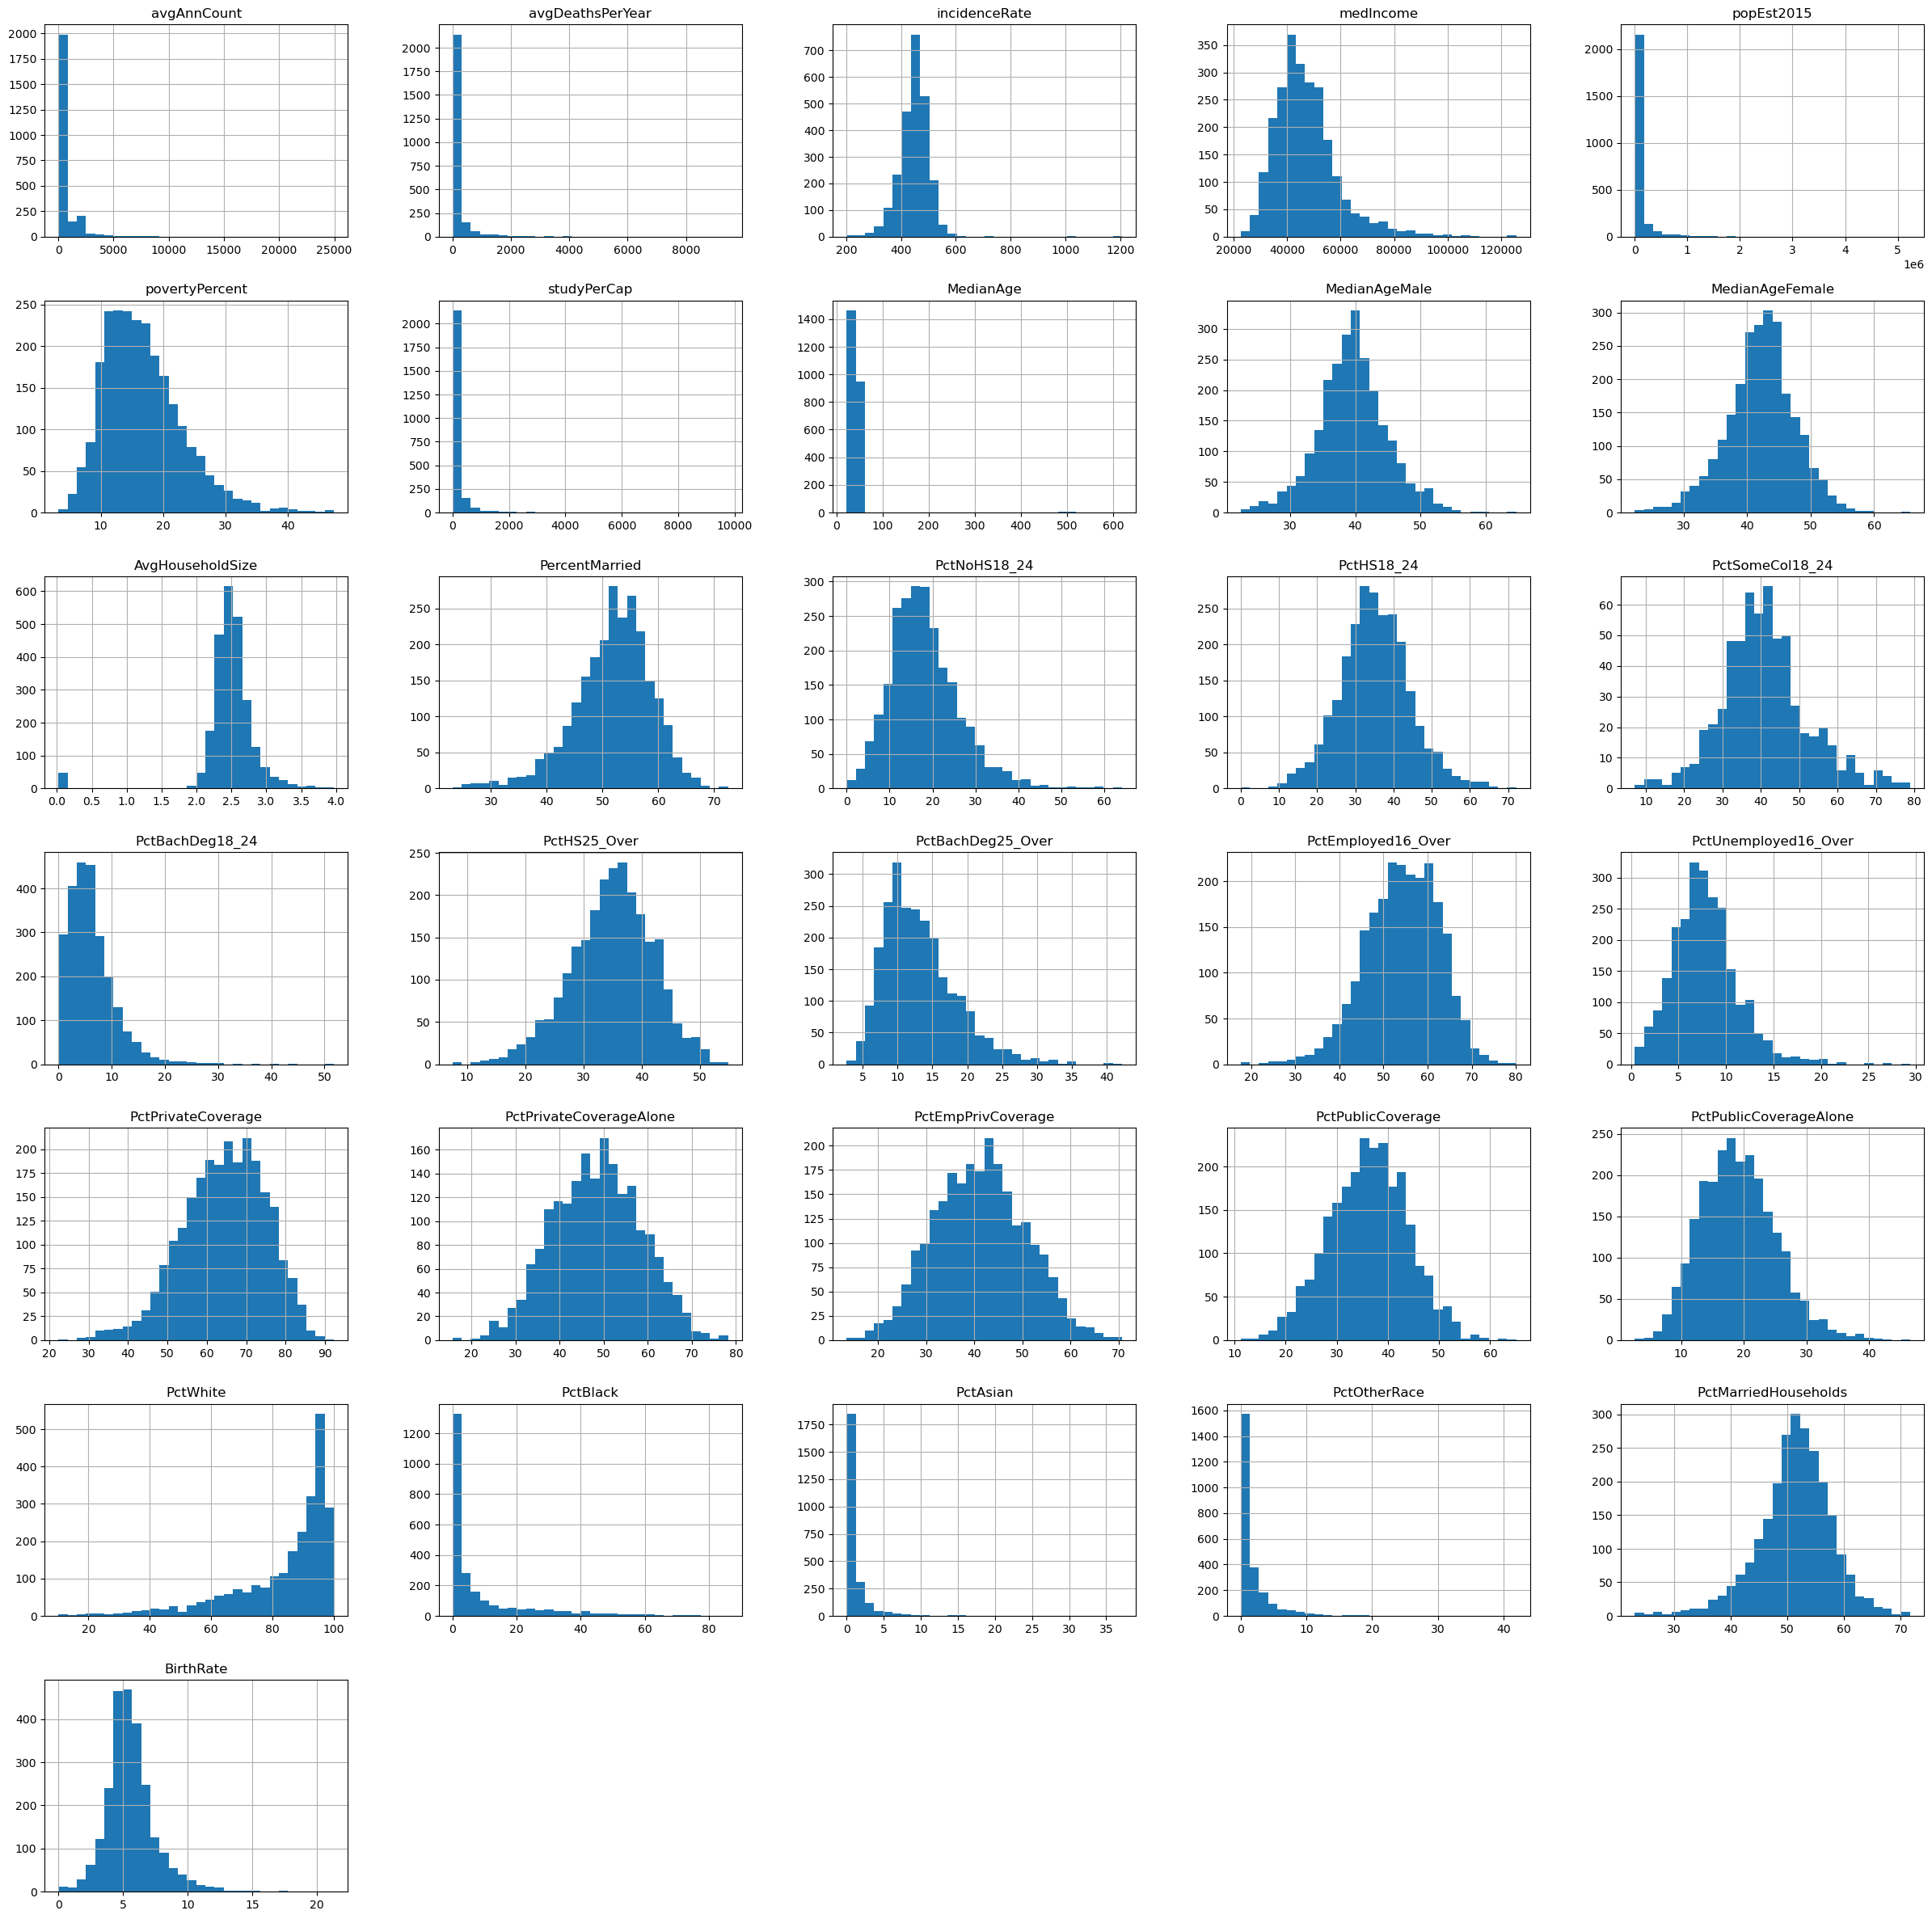

In [9]:
train_x.hist(bins=30,layout= (7,5), figsize=(30, 30));

From the above histograms, it is evident that the variables avgAnnCount, avgDeathsPerYear, popEst2015, studyPerCap, MedianAge ,PctBachDeg18_24, PctWhite,PctBlack,PctAsian,PctOtherRace have highly skewed distribution and require boxplots to verify the outliers for the rest of the variables.

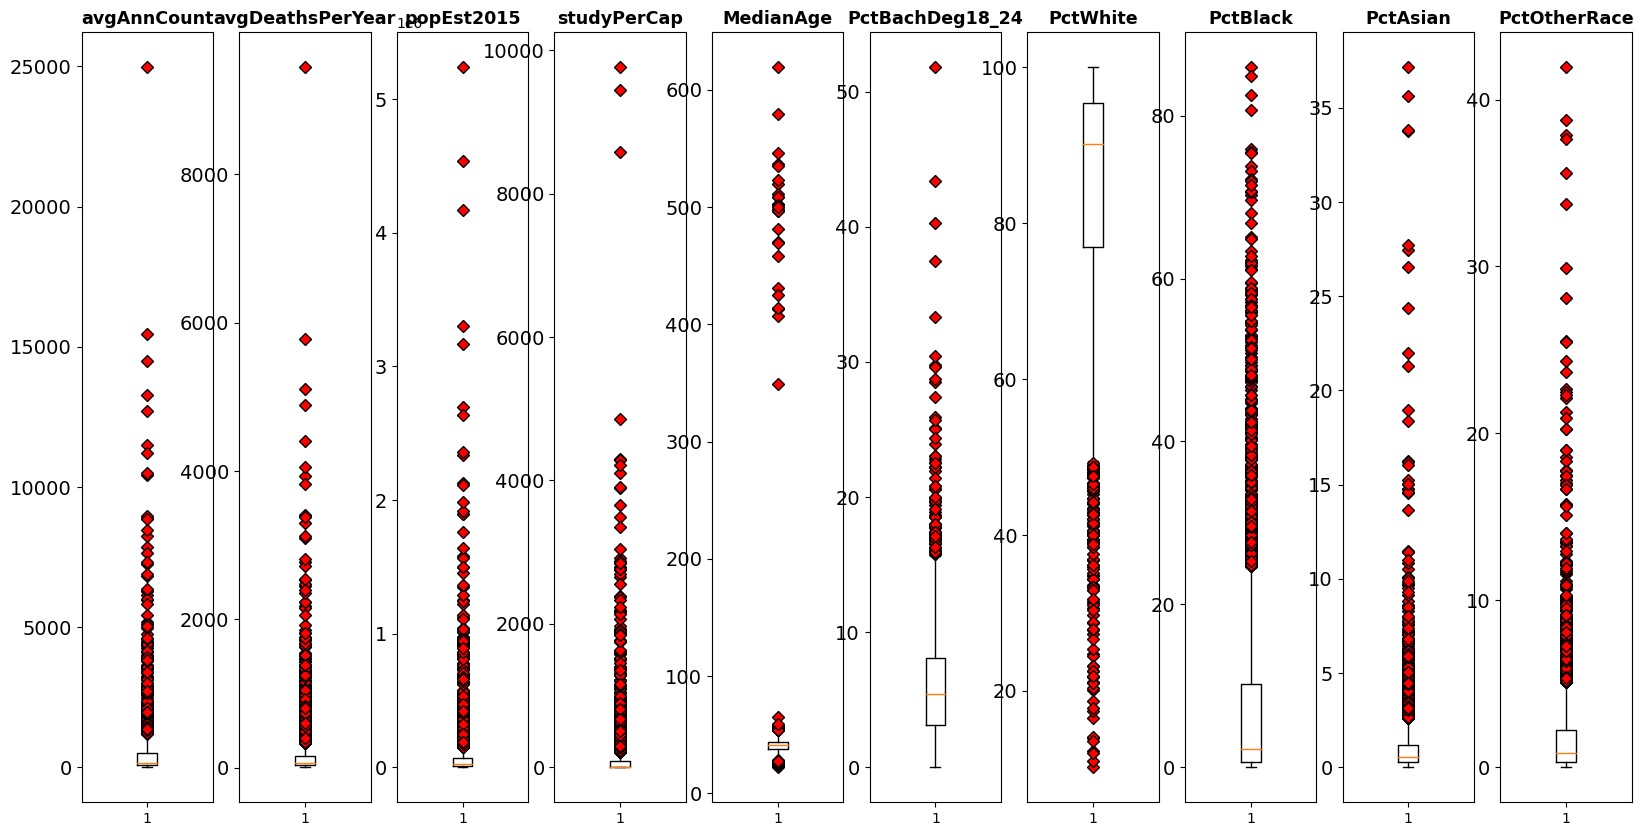

In [10]:
remaining_cols = ["avgAnnCount", "avgDeathsPerYear", "popEst2015", "studyPerCap", "MedianAge" ,"PctBachDeg18_24", 
        "PctWhite","PctBlack","PctAsian","PctOtherRace"]
box_df = train_x[remaining_cols]
green_diamond = dict(markerfacecolor='red', marker='D')
fig , axs = plt.subplots(1,len(box_df.columns),figsize= (20,10))

for j, ax in enumerate(axs.flat):
    ax.boxplot(box_df.iloc[:,j],flierprops=green_diamond)
    ax.set_title(box_df.columns[j],fontsize = 12.6,fontweight="bold")
    ax.tick_params(axis="y",labelsize =14)
    #ax.semilogy() # log scale shows beautiful boxplots

For the skewed distributions, boxplots are the best way to visualise outliers.There are so many outliers shown by the green coloured diamond points. The orange coloured line in between the box represents the mean. A value of zero is assigned to 1548 rows out of 2438 records. This value seems a bit off from the other columns.

# Bivariate analysis using BoxPlots

All of the features correlations to the target variable are moderate andnot very strong. The correlation coefficients below 0.5 In comparison to other variables, PctBachDeg25 Over, incidenceRate, PctPublicCoverageAlone, andmed are the top 5 features withthe highest association. earnings; poverty percent, with PctBachDeg25 Over and med as the two variables. 
Target andincome have a negative correlation, but the other variables have a positive correlation.

In [11]:
corr_values5 = (train_x.corrwith(train_y.TARGET_deathRate)).sort_values(ascending=False,key=abs)[0:5].to_frame().reset_index()
corr_values5.rename(columns={corr_values5.columns[0]: 'Variables_names',corr_values5.columns[1]: 'Correlation_value'},inplace=True)
corr_values5

,Variables_names,Correlation_value
0,PctBachDeg25_Over,-0.491411
1,incidenceRate,0.443983
2,PctPublicCoverageAlone,0.439734
3,medIncome,-0.416607
4,povertyPercent,0.413260


PctPublicCoverageAlone from the (3,5) dimension of the matrix revealed a substantial positive association with povertyPercent. Additionally, PCtBachDeg25 Over and medIncome have a substantial positive link, which is understandable given that persons with higher education tend to earn more as they are more likely to find rewarding employment. investigating these plots in detail.

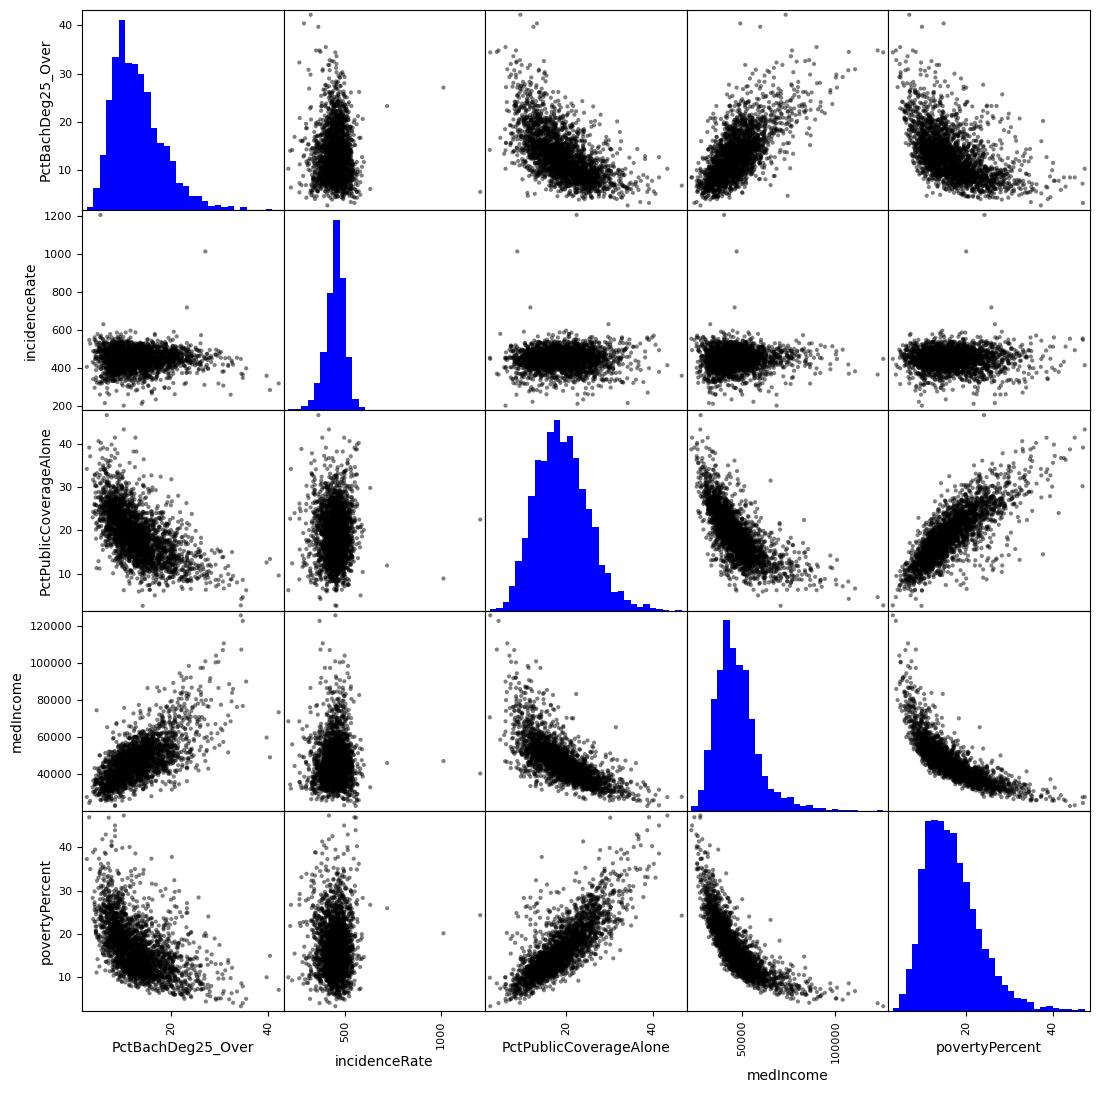

In [12]:
corr_frst5_var = corr_values5["Variables_names"].tolist()
corr_frst5_var
top_corr5 = train_x[corr_frst5_var]
pd.plotting.scatter_matrix(top_corr5,color = "black",figsize=(13,13),hist_kwds={'bins':30, 'color':'blue'});


### ML PIPELINE CREATION USING SCI-KIT LEARN 

# Dealing with missing values

All of the information in the training data is numerical. So, before taking any action, we will first determine which columns have the missing data. The three columns that are lacking data are PctSomeCol18 24, PctEmployed16 Over, and PctPrivateCoverageAlone, according to the code shown below.

In [13]:
train_x.columns[train_x.isna().any()].tolist()

['PctSomeCol18_24', 'PctEmployed16_Over', 'PctPrivateCoverageAlone']

In [14]:
print("The number of rows with missing values in variable 'PctSomeCol18_24' is ",len(train_x[train_x["PctSomeCol18_24"].isna()]))
print("The number of rows with missing values in variable 'PctEmployed16_Over' is ",len(train_x[train_x["PctEmployed16_Over"].isna()]))
print("The number of rows with missing values in variable 'PctPrivateCoverageAlone' is ",len(train_x[train_x["PctPrivateCoverageAlone"].isna()]))

The number of rows with missing values in variable 'PctSomeCol18_24' is  1829
The number of rows with missing values in variable 'PctEmployed16_Over' is  119
The number of rows with missing values in variable 'PctPrivateCoverageAlone' is  483


In [15]:
dropping_rows = train_x.drop('PctSomeCol18_24', axis=1)
new_var = list(dropping_rows)

class columnDropperTransformer(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [16]:
pipeline = Pipeline([
    ("columnDropper", columnDropperTransformer(new_var)),
    ("imputing",SimpleImputer(strategy="median")),
    ("Standardisation",StandardScaler())   
])

cancerData_train_x = pipeline.fit_transform(train_x)

Following the pipeline's execution, the column PctSomeCol18 24 is deleted, and all the missing data is replaced with the corresponding variable's median. The data is then standardised, which entails dividing by the standard deviation after deducting the mean from the data points. The output of fitting and transforming the pipeline is a 2D array.

Spiliting of training and testing sets 
We first split the data at 70-30% for training and test data respectively. This is because, the final test data we have is much less to decide on the model. so, we split the data using train_test_split.

In [17]:
CancerData_trainx_df = pd.DataFrame(cancerData_train_x,columns=dropping_rows.columns)
# making the test data split
X_train, X_test, y_train, y_test = train_test_split(cancerData_train_x, train_y.values, test_size=0.3, random_state=42)

# Random forest regression Model

Why choose random forest regressor? 
The resultant is 2-D array and being the ensemble method. my first choice for predicting the values is always starts with this model. Yet, linear regression seems more powerful. Ensemble methods always outstands the first and gives the best result. 

In [18]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,np.ravel(y_train))

RandomForestRegressor()

In [19]:
y_pred = forest_reg.predict(X_train)
MSE_forest_reg = mean_squared_error(y_train,y_pred)
RMSE_forest_reg = np.round(np.sqrt(MSE_forest_reg),6)
R2_forest_reg = np.round(r2_score(y_train, y_pred),6)
MAE_forest_reg = np.round(mean_absolute_error(y_train, y_pred),6)
print("RMSE for Random Forest regressor (training) is :", RMSE_forest_reg)
print("R2 Score for Random Forest regressor (training) is :", R2_forest_reg )
print("MAE for Random Forest regressor (training) is :", MAE_forest_reg )

RMSE for Random Forest regressor (training) is : 6.985623
R2 Score for Random Forest regressor (training) is : 0.935883
MAE for Random Forest regressor (training) is : 5.120685


In [20]:
y_pred = forest_reg.predict(X_test)
MSE_forest_reg = mean_squared_error(y_test,y_pred)
RMSE_forest_reg = np.round(np.sqrt(MSE_forest_reg),6)
R2_forest_reg = np.round(r2_score(y_test, y_pred),6)
MAE_forest_reg = np.round(mean_absolute_error(y_test, y_pred),6)
print("RMSE for Random Forest regressor (test) is :", RMSE_forest_reg)
print("R2 Score for Random Forest regressor (test) is :", R2_forest_reg )
print("MAE for Random Forest regressor (test) is :", MAE_forest_reg )

RMSE for Random Forest regressor (test) is : 19.354685
R2 Score for Random Forest regressor (test) is : 0.500249
MAE for Random Forest regressor (test) is : 14.007056


For training data, Random Forest performed well. Additionally, the MSE for the Random Forest regressor is high. Additionally, the random forest regressor has a somewhat lower R2 score. Let's now examine the significant attributes that the random forest regressor deemed to be the best.

Text(0.5, 1.0, 'Decreasing order of Important attributes in Random Forest')

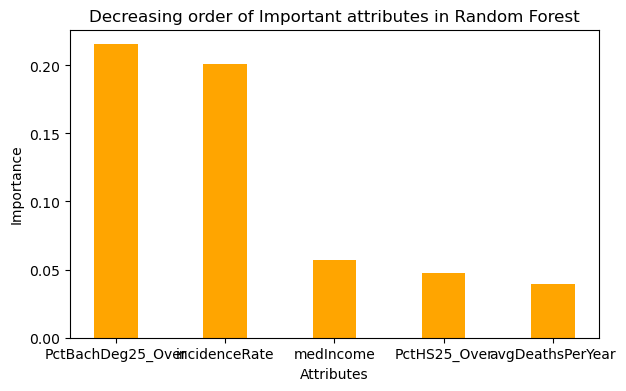

In [21]:
top_5_for_rf = pd.DataFrame(sorted(zip(forest_reg.feature_importances_,new_var),reverse=True)[0:5],
                            columns = ["Importance","Attribute"])

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.bar(top_5_for_rf["Attribute"],top_5_for_rf["Importance"],color ='orange',width = 0.4)
plt.xlabel("Attributes")
plt.ylabel("Importance")
plt.xticks(fontsize=10)
plt.title("Decreasing order of Important attributes in Random Forest")

# 2nd Model- Linear Regression Model

With the help of one or more independent variables that can most accurately predict the value of the dependent variable, this type of analysis calculates the coefficients of the linear equation. The differences between expected and actual output values are minimized by linear regression by fitting a straight line or surface. The best-fit line for a set of paired data may be found using straightforward linear regression calculators that employ the "least squares" technique. Then, using Y, you estimate the value of X (the dependent variable) (independent variable).

In [22]:
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [23]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_regression, k=25)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [24]:
X_train_fs, X_test_fs, fs = select_features(cancerData_train_x , train_y.to_numpy().reshape(-1), X_test)

In [25]:
def linear_Regression(X,y,X_test,y_test):
    clf = LinearRegression()
    clf.fit(X,y)
    Training_accuracy = clf.score(X,y)
    Testing_accuracy = clf.score(X_test,y_test)
    print("Accuracy percentage for Training Data is :",round(Training_accuracy*100,4))
    print("Accuracy percentage for Testing Data is :",round(Testing_accuracy*100,4))
    #To retrieve the intercept:
    print("\nBias for the Linear Regression Model :", clf.intercept_)
    #For retrieving the slope:
    print("Weights for the Linear Regression Model :",clf.coef_)
    #Prediction for Test data
    forecast = clf.predict(X_test)
    return forecast,Testing_accuracy

In [26]:
forecast,linear_accuracy = linear_Regression(cancerData_train_x,train_y,X_test,y_test)

Accuracy percentage for Training Data is : 52.794
Accuracy percentage for Testing Data is : 53.6371

Bias for the Linear Regression Model : [178.61710418]
Weights for the Linear Regression Model : [[-4.02966969  8.88610017 10.72415919  1.62748895 -5.79587516  2.40712465
   0.0188252  -0.22775546 -2.90228839  0.27765835 -0.1410111   7.9662115
  -1.12068357  2.26631946 -0.14020566  2.55132994 -7.43085516 -3.64053528
   0.25593573 -6.02334201  0.03973366  3.20703863 -3.02739968  1.97888299
  -2.60144967 -1.94799041  0.15499992 -3.19941815 -8.14286998 -1.85443934]]


# Conclusion

We may deduce from the above that, even if the Random Forest is best when compared to the metrics of the models, the Random Forest regressor performs better in pedicting the values of the unseen data with an about 10% greater accuracy. This is because, unlike the random forest regressor, which combines many base decision tree regressor models to create a single, superior predictive model, linear regression uses a single model.